In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import sqlite3
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer #transform different types
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from math import sqrt

In [2]:
import seaborn as sns
# Set the colour palette to coour-blind friendly
sns.reset_orig()
my_palette = sns.color_palette("colorblind")
plt.style.use('seaborn-colorblind')

In [3]:
os.chdir(r'C:\Users\geral\Repository\Coursework\Dataset')
print(os.getcwd())

C:\Users\geral\Repository\Coursework\Dataset


## Connecting to Database

In [4]:
conn = sqlite3.connect('pydatabase.db')

In [5]:
c = conn.cursor()

## Setup

**Goal is to select all the data in a state and build a Machine Learning model**

Previously in Question 2, we setup our data for a regression model. For this question, we will be using a similar approach. 

First lets load the entire data set of 2005 - 2006 on to the global environment. According to Question 3, we arranged the number of flights in the state in descending order. In the middle, is LA, Louisiana, with a total of 125,996 flights.

We choose state **LA, Louisiana**

In [6]:
state_LA = pd.read_sql_query('''SELECT * FROM Y05_06 JOIN airports ON Y05_06.Dest=airports.iata WHERE airports.state = 'LA' AND Cancelled = 0 AND Diverted = 0''', conn)
state_LA

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,NASDelay,SecurityDelay,LateAircraftDelay,iata,airport,city,state,country,lat,long
0,2005,1,1,6,932.0,940,1035.0,1046,EV,4349,...,0,0,0,AEX,Alexandria International,Alexandria,LA,USA,31.327372,-92.548556
1,2005,1,1,6,1335.0,1324,1405.0,1410,EV,4245,...,0,0,0,AEX,Alexandria International,Alexandria,LA,USA,31.327372,-92.548556
2,2005,1,1,6,1600.0,1600,1703.0,1710,EV,4552,...,0,0,0,AEX,Alexandria International,Alexandria,LA,USA,31.327372,-92.548556
3,2005,1,1,6,1626.0,1630,1728.0,1731,XE,2529,...,0,0,0,AEX,Alexandria International,Alexandria,LA,USA,31.327372,-92.548556
4,2005,1,1,6,1810.0,1802,1850.0,1854,EV,4280,...,0,0,0,AEX,Alexandria International,Alexandria,LA,USA,31.327372,-92.548556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125991,2006,12,31,7,1902.0,1848,1951.0,1950,XE,2731,...,0,0,0,SHV,Shreveport Regional,Shreveport,LA,USA,32.446627,-93.825598
125992,2006,12,31,7,2030.0,2035,2130.0,2130,MQ,3495,...,0,0,0,SHV,Shreveport Regional,Shreveport,LA,USA,32.446627,-93.825598
125993,2006,12,31,7,2035.0,2049,2140.0,2200,EV,4415,...,0,0,0,SHV,Shreveport Regional,Shreveport,LA,USA,32.446627,-93.825598
125994,2006,12,31,7,2100.0,2106,2143.0,2200,EV,4881,...,0,0,0,SHV,Shreveport Regional,Shreveport,LA,USA,32.446627,-93.825598


In [7]:
plane_data = pd.read_sql_query('''SELECT tailnum, manufacturer, model, status, plane_data.year AS Year_Manufactured
                                    FROM plane_data''', conn)
plane_data

,tailnum,manufacturer,model,status,Year_Manufactured
0,N050AA,None,None,None,None
1,N051AA,None,None,None,None
2,N052AA,None,None,None,None
3,N054AA,None,None,None,None
4,N055AA,None,None,None,None
...,...,...,...,...,...
5024,N997DL,MCDONNELL DOUGLAS AIRCRAFT CO,MD-88,Valid,1992
5025,N998AT,BOEING,717-200,Valid,2002
5026,N998DL,MCDONNELL DOUGLAS CORPORATION,MD-88,Valid,1992
5027,N999CA,CANADAIR,CL-600-2B19,Valid,1998


In [8]:
df_merged = pd.merge(state_LA,plane_data, how = 'left', 
                     left_on = 'TailNum', right_on = 'tailnum')
df_merged.dropna()
df_merged

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,city,state,country,lat,long,tailnum,manufacturer,model,status,Year_Manufactured
0,2005,1,1,6,932.0,940,1035.0,1046,EV,4349,...,Alexandria,LA,USA,31.327372,-92.548556,N885AS,BOMBARDIER INC,CL-600-2B19,Valid,2001
1,2005,1,1,6,1335.0,1324,1405.0,1410,EV,4245,...,Alexandria,LA,USA,31.327372,-92.548556,N851AS,BOMBARDIER INC,CL-600-2B19,Valid,1999
2,2005,1,1,6,1600.0,1600,1703.0,1710,EV,4552,...,Alexandria,LA,USA,31.327372,-92.548556,N900EV,BOMBARDIER INC,CL-600-2B19,Valid,2002
3,2005,1,1,6,1626.0,1630,1728.0,1731,XE,2529,...,Alexandria,LA,USA,31.327372,-92.548556,N27523,EMBRAER,EMB-135LR,Valid,2001
4,2005,1,1,6,1810.0,1802,1850.0,1854,EV,4280,...,Alexandria,LA,USA,31.327372,-92.548556,N857AS,BOMBARDIER INC,CL-600-2B19,Valid,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125991,2006,12,31,7,1902.0,1848,1951.0,1950,XE,2731,...,Shreveport,LA,USA,32.446627,-93.825598,N15980,EMBRAER,EMB-145LR,Valid,1999
125992,2006,12,31,7,2030.0,2035,2130.0,2130,MQ,3495,...,Shreveport,LA,USA,32.446627,-93.825598,N613AE,EMBRAER,EMB-145,Valid,1998
125993,2006,12,31,7,2035.0,2049,2140.0,2200,EV,4415,...,Shreveport,LA,USA,32.446627,-93.825598,N684BR,BOMBARDIER INC,CL-600-2B19,Valid,2002
125994,2006,12,31,7,2100.0,2106,2143.0,2200,EV,4881,...,Shreveport,LA,USA,32.446627,-93.825598,N919EV,BOMBARDIER INC,CL-600-2B19,Valid,2003


In [9]:
df_merged_LA = df_merged.copy()
df_merged_LA = df_merged_LA[['Year', 'Month', 'DayOfWeek', 'DepDelay', 'ArrDelay', 'CRSDepTime', 'CRSArrTime', 
                             'CRSElapsedTime', 'Year_Manufactured', 'status', 'manufacturer', 'Cancelled', 'Diverted']]
df_merged_LA

,Year,Month,DayOfWeek,DepDelay,ArrDelay,CRSDepTime,CRSArrTime,CRSElapsedTime,Year_Manufactured,status,manufacturer,Cancelled,Diverted
0,2005,1,6,-8.0,-11.0,940,1046,66.0,2001,Valid,BOMBARDIER INC,0,0
1,2005,1,6,11.0,-5.0,1324,1410,106.0,1999,Valid,BOMBARDIER INC,0,0
2,2005,1,6,0.0,-7.0,1600,1710,70.0,2002,Valid,BOMBARDIER INC,0,0
3,2005,1,6,-4.0,-3.0,1630,1731,61.0,2001,Valid,EMBRAER,0,0
4,2005,1,6,8.0,-4.0,1802,1854,112.0,2000,Valid,BOMBARDIER INC,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125991,2006,12,7,14.0,1.0,1848,1950,62.0,1999,Valid,EMBRAER,0,0
125992,2006,12,7,-5.0,0.0,2035,2130,55.0,1998,Valid,EMBRAER,0,0
125993,2006,12,7,-14.0,-20.0,2049,2200,131.0,2002,Valid,BOMBARDIER INC,0,0
125994,2006,12,7,-6.0,-17.0,2106,2200,114.0,2003,Valid,BOMBARDIER INC,0,0


In [10]:
df_merged_LA.drop(df_merged_LA[df_merged_LA['Year_Manufactured'] == 'None'].index, inplace = True)
df_merged_LA.drop(df_merged_LA[df_merged_LA['Year_Manufactured'] == '0000'].index, inplace = True)
df_merged_LA.dropna(inplace = True)

df_merged_LA['Year_Manufactured'].unique()

array(['2001', '1999', '2002', '2000', '1997', '2003', '1998', '1996',
       '2004', '2005', '2006', '1968', '1994', '1969', '1967', '1975',
       '1973', '1993', '1979', '1995', '1976', '1970', '1980', '1978',
       '1988', '1991', '1990', '1965', '1977', '1986', '1987', '1971',
       '1989', '1992', '1984', '1983', '1974', '1985', '1982', '1962',
       '2007', '1964', '1963', '1959', '1957', '1966'], dtype=object)

Creating Age, old and seasons DV

In [11]:
df_merged_LA['Year_Manufactured'] = df_merged_LA['Year_Manufactured'].astype(float).astype(int) 

df_merged_LA = df_merged_LA.assign(Age = df_merged_LA.Year - df_merged_LA.Year_Manufactured)
df_merged_LA

,Year,Month,DayOfWeek,DepDelay,ArrDelay,CRSDepTime,CRSArrTime,CRSElapsedTime,Year_Manufactured,status,manufacturer,Cancelled,Diverted,Age
0,2005,1,6,-8.0,-11.0,940,1046,66.0,2001,Valid,BOMBARDIER INC,0,0,4
1,2005,1,6,11.0,-5.0,1324,1410,106.0,1999,Valid,BOMBARDIER INC,0,0,6
2,2005,1,6,0.0,-7.0,1600,1710,70.0,2002,Valid,BOMBARDIER INC,0,0,3
3,2005,1,6,-4.0,-3.0,1630,1731,61.0,2001,Valid,EMBRAER,0,0,4
4,2005,1,6,8.0,-4.0,1802,1854,112.0,2000,Valid,BOMBARDIER INC,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125991,2006,12,7,14.0,1.0,1848,1950,62.0,1999,Valid,EMBRAER,0,0,7
125992,2006,12,7,-5.0,0.0,2035,2130,55.0,1998,Valid,EMBRAER,0,0,8
125993,2006,12,7,-14.0,-20.0,2049,2200,131.0,2002,Valid,BOMBARDIER INC,0,0,4
125994,2006,12,7,-6.0,-17.0,2106,2200,114.0,2003,Valid,BOMBARDIER INC,0,0,3


In [12]:
# using our function Q2 to create Old Dummy variable
def DV(Age):
    '''
    We create a fuunction for the creation of dummy variables. 
    For planes with the age of 10 and more or Year_Manufactured <= 1996 are considered old.
    Hence Old = 1, 0 otherwise.
    '''
    if (Age >= 10):
        return '1'
    else:
        return '0'
    

In [13]:
df_merged_LA['Old'] = df_merged_LA['Age'].apply(DV)
df_merged_LA

,Year,Month,DayOfWeek,DepDelay,ArrDelay,CRSDepTime,CRSArrTime,CRSElapsedTime,Year_Manufactured,status,manufacturer,Cancelled,Diverted,Age,Old
0,2005,1,6,-8.0,-11.0,940,1046,66.0,2001,Valid,BOMBARDIER INC,0,0,4,0
1,2005,1,6,11.0,-5.0,1324,1410,106.0,1999,Valid,BOMBARDIER INC,0,0,6,0
2,2005,1,6,0.0,-7.0,1600,1710,70.0,2002,Valid,BOMBARDIER INC,0,0,3,0
3,2005,1,6,-4.0,-3.0,1630,1731,61.0,2001,Valid,EMBRAER,0,0,4,0
4,2005,1,6,8.0,-4.0,1802,1854,112.0,2000,Valid,BOMBARDIER INC,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125991,2006,12,7,14.0,1.0,1848,1950,62.0,1999,Valid,EMBRAER,0,0,7,0
125992,2006,12,7,-5.0,0.0,2035,2130,55.0,1998,Valid,EMBRAER,0,0,8,0
125993,2006,12,7,-14.0,-20.0,2049,2200,131.0,2002,Valid,BOMBARDIER INC,0,0,4,0
125994,2006,12,7,-6.0,-17.0,2106,2200,114.0,2003,Valid,BOMBARDIER INC,0,0,3,0


In [14]:
Summer = df_merged_LA[df_merged_LA['Month'].isin([6,7,8])]

i = len(Summer)
i

Summer['SummerDV'] = np.repeat(0,i)
Summer['FallDV'] = np.repeat(1,i)
Summer['SpringDV'] = np.repeat(0,i)

Summer

C:\Users\geral\AppData\Local\Temp/ipykernel_18504/2995203696.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Summer['SummerDV'] = np.repeat(0,i)
C:\Users\geral\AppData\Local\Temp/ipykernel_18504/2995203696.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Summer['FallDV'] = np.repeat(1,i)
C:\Users\geral\AppData\Local\Temp/ipykernel_18504/2995203696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,Year,Month,DayOfWeek,DepDelay,ArrDelay,CRSDepTime,CRSArrTime,CRSElapsedTime,Year_Manufactured,status,manufacturer,Cancelled,Diverted,Age,Old,SummerDV,FallDV,SpringDV
1119,2005,6,3,0.0,7.0,920,1020,60.0,1998,Valid,EMBRAER,0,0,7,0,0,1,0
1120,2005,6,3,51.0,51.0,1210,1308,58.0,2001,Valid,EMBRAER,0,0,4,0,0,1,0
1121,2005,6,3,-2.0,-5.0,1535,1630,55.0,1998,Valid,EMBRAER,0,0,7,0,0,1,0
1122,2005,6,3,0.0,-9.0,1735,1816,101.0,1998,Valid,CANADAIR,0,0,7,0,0,1,0
1123,2005,6,3,-3.0,4.0,1920,2030,70.0,2001,Valid,EMBRAER,0,0,4,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123507,2006,8,4,53.0,54.0,1812,1901,109.0,2002,Valid,BOMBARDIER INC,0,0,4,0,0,1,0
123508,2006,8,4,89.0,78.0,1820,1913,113.0,2004,Valid,BOMBARDIER INC,0,0,2,0,0,1,0
123509,2006,8,4,-1.0,-9.0,2115,2210,55.0,2003,Valid,EMBRAER,0,0,3,0,0,1,0
123510,2006,8,4,-1.0,15.0,2120,2216,56.0,2005,Valid,EMBRAER,0,0,1,0,0,1,0


In [15]:
Fall = df_merged_LA[df_merged_LA['Month'].isin([9,10,11])]

i = len(Fall)
i

Fall['SummerDV'] = np.repeat(0,i)
Fall['FallDV'] = np.repeat(1,i)
Fall['SpringDV'] = np.repeat(0,i)

Fall

C:\Users\geral\AppData\Local\Temp/ipykernel_18504/4236048377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fall['SummerDV'] = np.repeat(0,i)
C:\Users\geral\AppData\Local\Temp/ipykernel_18504/4236048377.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fall['FallDV'] = np.repeat(1,i)
C:\Users\geral\AppData\Local\Temp/ipykernel_18504/4236048377.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,Year,Month,DayOfWeek,DepDelay,ArrDelay,CRSDepTime,CRSArrTime,CRSElapsedTime,Year_Manufactured,status,manufacturer,Cancelled,Diverted,Age,Old,SummerDV,FallDV,SpringDV
1652,2005,9,4,-7.0,4.0,920,1018,58.0,1997,Valid,EMBRAER,0,0,8,0,0,1,0
1653,2005,9,4,4.0,-13.0,1115,1156,101.0,1997,Valid,CANADAIR,0,0,8,0,0,1,0
1654,2005,9,4,12.0,21.0,1535,1635,60.0,2003,Valid,EMBRAER,0,0,2,0,0,1,0
1655,2005,9,4,41.0,33.0,1700,1740,100.0,2001,Valid,BOMBARDIER INC,0,0,4,0,0,1,0
1656,2005,9,4,18.0,20.0,1925,2035,70.0,2003,Valid,EMBRAER,0,0,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125355,2006,11,4,77.0,95.0,1855,1955,60.0,1999,Valid,EMBRAER,0,0,7,0,0,1,0
125356,2006,11,4,-5.0,8.0,2055,2201,126.0,1998,Valid,BOMBARDIER INC,0,0,8,0,0,1,0
125357,2006,11,4,10.0,21.0,2115,2204,109.0,1997,Valid,CANADAIR,0,0,9,0,0,1,0
125358,2006,11,4,34.0,35.0,2120,2216,56.0,2005,Valid,EMBRAER,0,0,1,0,0,1,0


In [16]:
Spring = df_merged_LA[df_merged_LA['Month'].isin([3,4,5])]

i = len(Spring)
i

Spring['SummerDV'] = np.repeat(0,i)
Spring['FallDV'] = np.repeat(0,i)
Spring['SpringDV'] = np.repeat(1,i)

Spring

C:\Users\geral\AppData\Local\Temp/ipykernel_18504/4062424785.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spring['SummerDV'] = np.repeat(0,i)
C:\Users\geral\AppData\Local\Temp/ipykernel_18504/4062424785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spring['FallDV'] = np.repeat(0,i)
C:\Users\geral\AppData\Local\Temp/ipykernel_18504/4062424785.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,Year,Month,DayOfWeek,DepDelay,ArrDelay,CRSDepTime,CRSArrTime,CRSElapsedTime,Year_Manufactured,status,manufacturer,Cancelled,Diverted,Age,Old,SummerDV,FallDV,SpringDV
436,2005,3,2,-7.0,-14.0,920,1021,61.0,1997,Valid,EMBRAER,0,0,8,0,0,0,1
437,2005,3,2,-5.0,-9.0,1114,1159,105.0,2003,Valid,BOMBARDIER INC,0,0,2,0,0,0,1
438,2005,3,2,-1.0,3.0,1535,1632,57.0,1997,Valid,EMBRAER,0,0,8,0,0,0,1
439,2005,3,2,38.0,33.0,1720,1805,105.0,2001,Valid,BOMBARDIER INC,0,0,4,0,0,0,1
440,2005,3,2,16.0,16.0,1820,1918,58.0,1997,Valid,EMBRAER,0,0,8,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121761,2006,5,3,-4.0,-7.0,1817,1900,103.0,2001,Valid,BOMBARDIER INC,0,0,5,0,0,0,1
121763,2006,5,3,37.0,34.0,1846,1939,53.0,2001,Valid,EMBRAER,0,0,5,0,0,0,1
121764,2006,5,3,27.0,16.0,1950,2103,73.0,1996,Valid,EMBRAER,0,0,10,1,0,0,1
121765,2006,5,3,47.0,34.0,2120,2219,59.0,2002,Valid,EMBRAER,0,0,4,0,0,0,1


In [17]:
Winter = df_merged_LA[df_merged_LA['Month'].isin([1,2,12])]

i = len(Winter)
i

Winter['SummerDV'] = np.repeat(0,i)
Winter['FallDV'] = np.repeat(0,i)
Winter['SpringDV'] = np.repeat(0,i)

Winter

C:\Users\geral\AppData\Local\Temp/ipykernel_18504/59781584.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Winter['SummerDV'] = np.repeat(0,i)
C:\Users\geral\AppData\Local\Temp/ipykernel_18504/59781584.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Winter['FallDV'] = np.repeat(0,i)
C:\Users\geral\AppData\Local\Temp/ipykernel_18504/59781584.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,Year,Month,DayOfWeek,DepDelay,ArrDelay,CRSDepTime,CRSArrTime,CRSElapsedTime,Year_Manufactured,status,manufacturer,Cancelled,Diverted,Age,Old,SummerDV,FallDV,SpringDV
0,2005,1,6,-8.0,-11.0,940,1046,66.0,2001,Valid,BOMBARDIER INC,0,0,4,0,0,0,0
1,2005,1,6,11.0,-5.0,1324,1410,106.0,1999,Valid,BOMBARDIER INC,0,0,6,0,0,0,0
2,2005,1,6,0.0,-7.0,1600,1710,70.0,2002,Valid,BOMBARDIER INC,0,0,3,0,0,0,0
3,2005,1,6,-4.0,-3.0,1630,1731,61.0,2001,Valid,EMBRAER,0,0,4,0,0,0,0
4,2005,1,6,8.0,-4.0,1802,1854,112.0,2000,Valid,BOMBARDIER INC,0,0,5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125991,2006,12,7,14.0,1.0,1848,1950,62.0,1999,Valid,EMBRAER,0,0,7,0,0,0,0
125992,2006,12,7,-5.0,0.0,2035,2130,55.0,1998,Valid,EMBRAER,0,0,8,0,0,0,0
125993,2006,12,7,-14.0,-20.0,2049,2200,131.0,2002,Valid,BOMBARDIER INC,0,0,4,0,0,0,0
125994,2006,12,7,-6.0,-17.0,2106,2200,114.0,2003,Valid,BOMBARDIER INC,0,0,3,0,0,0,0


In [18]:
test = pd.concat([Summer,Spring,Fall,Winter])
test

,Year,Month,DayOfWeek,DepDelay,ArrDelay,CRSDepTime,CRSArrTime,CRSElapsedTime,Year_Manufactured,status,manufacturer,Cancelled,Diverted,Age,Old,SummerDV,FallDV,SpringDV
1119,2005,6,3,0.0,7.0,920,1020,60.0,1998,Valid,EMBRAER,0,0,7,0,0,1,0
1120,2005,6,3,51.0,51.0,1210,1308,58.0,2001,Valid,EMBRAER,0,0,4,0,0,1,0
1121,2005,6,3,-2.0,-5.0,1535,1630,55.0,1998,Valid,EMBRAER,0,0,7,0,0,1,0
1122,2005,6,3,0.0,-9.0,1735,1816,101.0,1998,Valid,CANADAIR,0,0,7,0,0,1,0
1123,2005,6,3,-3.0,4.0,1920,2030,70.0,2001,Valid,EMBRAER,0,0,4,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125991,2006,12,7,14.0,1.0,1848,1950,62.0,1999,Valid,EMBRAER,0,0,7,0,0,0,0
125992,2006,12,7,-5.0,0.0,2035,2130,55.0,1998,Valid,EMBRAER,0,0,8,0,0,0,0
125993,2006,12,7,-14.0,-20.0,2049,2200,131.0,2002,Valid,BOMBARDIER INC,0,0,4,0,0,0,0
125994,2006,12,7,-6.0,-17.0,2106,2200,114.0,2003,Valid,BOMBARDIER INC,0,0,3,0,0,0,0


### Split into Training and Test Datasets
We look at two cases, first we include DepDelay and second if we exclude depdelay.

## 1) With DepDelay

In [19]:
# features from the dataset
features = ['DepDelay', 'Month','DayOfWeek','Age', 'Old', 'CRSArrTime','CRSDepTime','CRSElapsedTime', 'SummerDV', 'FallDV', 'SpringDV']
X = test[features].copy()
y = test['ArrDelay'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Pipelines: Pre-Processing Stage

In [20]:
numerical_features = features
# Applying SimpleImputer and StandardScaler into a pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

In [21]:
data_transformer = ColumnTransformer(
    transformers=[('numerical', numerical_transformer, numerical_features)]) 

In [22]:
# Important note: Parameters of pipelines are set using '__' separated parameter names
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median','most_frequent']
}

### Pipeline with Linear Regression

In [23]:
pipe_lm = Pipeline(steps=[('data_transformer', data_transformer),
                          ('pipe_lm', LinearRegression())])

grid_lm = GridSearchCV(pipe_lm, param_grid=param_grid) #default cv is 5-fold
grid_lm.fit(X_train, y_train);

In [24]:
print(grid_lm.best_score_)  #mean cross-validated score of the best_estimator
print(grid_lm.best_params_)
#print(grid_lm.best_estimator_)

#Reference -- https://scikit-learn.org/stable/modules/grid_search.html#specifying-an-objective-metric
#By default, parameter search uses the score function of the estimator to evaluate a parameter 
#setting. These are the sklearn.metrics.accuracy_score for classification and 
#sklearn.metrics.r2_score for regression.

0.8293399613936797
{'data_transformer__numerical__imputer__strategy': 'mean'}


In [25]:
#grid_lm.cv_results_

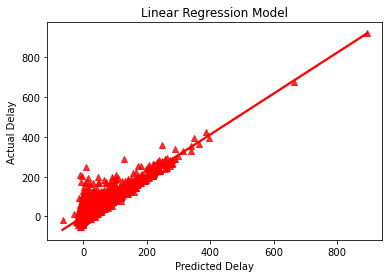

In [26]:
y_predict_lm = grid_lm.predict(X_test)

sns.regplot(x=y_predict_lm, y=y_test, color='red', marker="^")
plt.xlabel("Predicted Delay")
plt.ylabel("Actual Delay")
plt.title("Linear Regression Model")
plt.show()

In [27]:
RMSE= np.sqrt(mean_squared_error(y_test, y_predict_lm))
MSE= mean_squared_error(y_test, y_predict_lm)
MAE= mean_absolute_error(y_test, y_predict_lm)
r2= r2_score(y_test, y_predict_lm)

print('RMSE =', RMSE)
print('MSE =', MSE)
print('MAE =', MAE)
print('R2 =', r2) 

RMSE = 12.29772658079919
MSE = 151.2340790560949
MAE = 8.093714983308148
R2 = 0.8558044798705058


### Pipeline with Random Forest Regressor

In [28]:
pipe_rf = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_rf', RandomForestRegressor(random_state=0))])

grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid)
grid_rf.fit(X_train, y_train);

In [29]:
print(grid_rf.best_score_)
print(grid_rf.best_params_)
#print(grid_rf.best_estimator_)

0.8526754761197315
{'data_transformer__numerical__imputer__strategy': 'mean'}


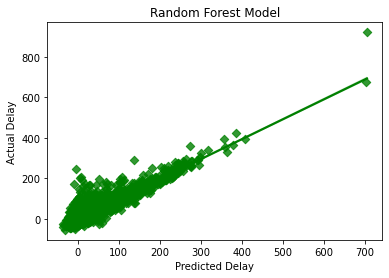

In [30]:
y_predict_rf = grid_rf.predict(X_test)

sns.regplot(x=y_predict_rf, y=y_test, color = 'green', marker = "D")
plt.xlabel("Predicted Delay")
plt.ylabel("Actual Delay")
plt.title("Random Forest Model")
plt.show()

In [31]:
RMSE= np.sqrt(mean_squared_error(y_test, y_predict_rf))
MSE= mean_squared_error(y_test, y_predict_rf)
MAE= mean_absolute_error(y_test, y_predict_rf)
r2= r2_score(y_test, y_predict_rf)

print('RMSE =', RMSE)
print('MSE =', MSE)
print('MAE =', MAE)
print('R2 =', r2) 

RMSE = 12.346788847396574
MSE = 152.44319484219645
MAE = 8.109917696404665
R2 = 0.8546516373315631


## 2) Without DepDelay

In [33]:
# features from the dataset
features = ['Month','DayOfWeek','Age', 'Old', 'CRSArrTime','CRSDepTime','CRSElapsedTime', 'SummerDV', 'FallDV', 'SpringDV']
X = test[features].copy()
y = test['ArrDelay'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Pipelines: Pre-Processing Stage

In [34]:
numerical_features = features
# Applying SimpleImputer and StandardScaler into a pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

In [35]:
data_transformer = ColumnTransformer(
    transformers=[('numerical', numerical_transformer, numerical_features)]) 

In [36]:
# Important note: Parameters of pipelines are set using '__' separated parameter names
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median','most_frequent']
}

### Pipeline with Linear Regression

In [37]:
pipe_lm = Pipeline(steps=[('data_transformer', data_transformer),
                          ('pipe_lm', LinearRegression())])

grid_lm = GridSearchCV(pipe_lm, param_grid=param_grid) #default cv is 5-fold
grid_lm.fit(X_train, y_train);

In [38]:
print(grid_lm.best_score_)  #mean cross-validated score of the best_estimator
print(grid_lm.best_params_)
#print(grid_lm.best_estimator_)

#Reference -- https://scikit-learn.org/stable/modules/grid_search.html#specifying-an-objective-metric
#By default, parameter search uses the score function of the estimator to evaluate a parameter 
#setting. These are the sklearn.metrics.accuracy_score for classification and 
#sklearn.metrics.r2_score for regression.

0.023175621939129476
{'data_transformer__numerical__imputer__strategy': 'mean'}


In [39]:
#grid_lm.cv_results_

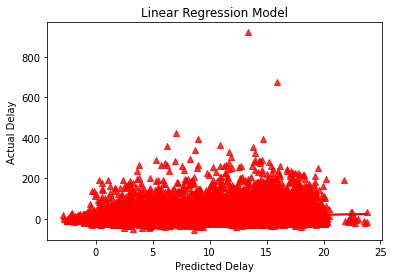

In [40]:
y_predict_lm = grid_lm.predict(X_test)

sns.regplot(x=y_predict_lm, y=y_test, color='red', marker="^")
plt.xlabel("Predicted Delay")
plt.ylabel("Actual Delay")
plt.title("Linear Regression Model")
plt.show()

In [41]:
RMSE= np.sqrt(mean_squared_error(y_test, y_predict_lm))
MSE= mean_squared_error(y_test, y_predict_lm)
MAE= mean_absolute_error(y_test, y_predict_lm)
r2= r2_score(y_test, y_predict_lm)

print('RMSE =', RMSE)
print('MSE =', MSE)
print('MAE =', MAE)
print('R2 =', r2) 

RMSE = 31.98778395377734
MSE = 1023.2183222735349
MAE = 19.497862874375045
R2 = 0.024403103406774318


### Pipeline with Random Forest Regressor

In [42]:
pipe_rf = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_rf', RandomForestRegressor(random_state=0))])

grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid)
grid_rf.fit(X_train, y_train);

In [43]:
print(grid_rf.best_score_)
print(grid_rf.best_params_)
#print(grid_rf.best_estimator_)

-0.12469653616532281
{'data_transformer__numerical__imputer__strategy': 'mean'}


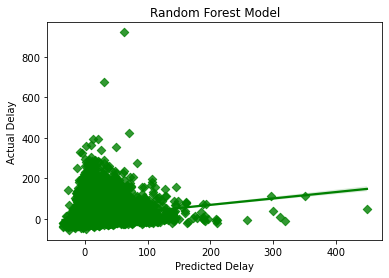

In [44]:
y_predict_rf = grid_rf.predict(X_test)

sns.regplot(x=y_predict_rf, y=y_test, color = 'green', marker = "D")
plt.xlabel("Predicted Delay")
plt.ylabel("Actual Delay")
plt.title("Random Forest Model")
plt.show()

In [45]:
RMSE= np.sqrt(mean_squared_error(y_test, y_predict_rf))
MSE= mean_squared_error(y_test, y_predict_rf)
MAE= mean_absolute_error(y_test, y_predict_rf)
r2= r2_score(y_test, y_predict_rf)

print('RMSE =', RMSE)
print('MSE =', MSE)
print('MAE =', MAE)
print('R2 =', r2) 

RMSE = 34.58089771436962
MSE = 1195.838486731694
MAE = 20.797605847662794
R2 = -0.14018317604979336


## Disconnecting from the Database

In [47]:
conn.close()